In [32]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
from tqdm import tqdm
import os
import pickle

In [33]:
from b2heavy.ThreePointFunctions.globalfit import RatioSet, show
from b2heavy.ThreePointFunctions.utils     import dump_fit_object, read_config_fit

In [48]:
from b2heavy.FnalHISQMetadata import params
from b2heavy.TwoPointFunctions import utils

config = utils.load_toml('/Users/pietro/code/software/B2heavy/routines/2pts_fit_config_Dst.toml')

for ens in ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']:
    tr = config['fit'][ens]['Dst']['mom']['200']['trange']
    
    mdata = params(ens)
    a = mdata['aSpc']

    print(ens,tr,np.array(tr)*a.mean)


MediumCoarse [4, 0.25] [0.59783746 0.03736484]
Coarse-2 [5, 0.25] [0.61944344 0.03097217]
Coarse-1 [5, 0.25] [0.61009468 0.03050473]
Coarse-Phys [5, 0.25] [0.60488425 0.03024421]
Fine-1 [7, 0.25] [0.62169024 0.02220322]
Fine-Phys [7, 0.25] [0.6162301  0.02200822]
SuperFine [11, 0.25] [0.6259836 0.0142269]


In [3]:
def jkerr(ndarray,**kwargs):
    if np.ndim(ndarray)==1:
        return gv.gvar(
            np.mean(ndarray),
            np.std(ndarray) * np.sqrt(len(ndarray)-1)
        )
    else:
        return gv.gvar(
            np.mean(ndarray),
            np.cov(ndarray,**kwargs) * (len(ndarray)-1)
        )

def format(vec):
    if isinstance(vec,(np.ndarray,list)):
        return jkerr(vec)
    else:
        return vec

In [4]:
readfrom = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'

In [20]:
MESON = 'D'
JK = True

In [21]:
RATIO_LIST = {
    'Dst': ['RA1','ZRA1','XFSTPAR','R0','R1','XV'],
    'D':   ['RPLUS','QPLUS','RMINUS','XF'],
}

ENSEMBLE_LIST = {
    'Dst':['Coarse-2','Coarse-1','Coarse-Phys','Fine-1'],
    'D'  :['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine'],
}


In [22]:
Rs = {}
for ens in ENSEMBLE_LIST[MESON]:
    # Read fit data
    tag = f'fit3pt_config_{ens}_{MESON}_global'
    out  = read_config_fit(tag,path=readfrom,jk=JK)
    pars = out if JK else out[-1]

    # Gather ratio values
    f0 = {}
    for k in pars:
        if k.endswith('f0'):
            rat,mom,_ = k.split('_')
            f0[mom,rat] = pars[k]

    momlist = sorted(set([m[0] for m in f0]))
    
    for mom in momlist:
        Rs[ens,mom] = {}
        for ratio in RATIO_LIST[MESON]:
            if (mom,ratio) in f0:
                r = ratio if ratio!='ZRA1' else 'RA1'
                Rs[ens,mom][r] = f0[mom,ratio]

                if r=='RA1':
                    Rs[ens,mom][r] = np.sqrt(Rs[ens,mom][r])

                if JK:
                    Njk = len(f0[mom,ratio])

        if mom=='000':
            Rs[ens,mom]['w'] = np.full(Njk,1.) if JK else gv.gvar('1.000000000(1)')
        else:
            xf = Rs[ens,mom]['XF' if MESON=='D' else 'XFSTPAR']
            Rs[ens,mom]['w'] = (1+xf**2)/(1-xf**2)

            if MESON=='D':
                Rs[ens,mom]['RPLUS'] = Rs[ens,'000']['RPLUS']

In [23]:
pd.DataFrame(Rs).transpose().map(format)

RPLUS             w        QPLUS        RMINUS  \
MediumCoarse 000  1.0164(48)          1(0)          NaN           NaN   
             100  1.0164(48)   1.01100(35)   0.9900(27)   -0.0831(16)   
             200  1.0164(48)   1.04195(94)   0.9642(47)   -0.1603(23)   
             300  1.0164(48)    1.0862(21)   0.9292(80)   -0.2251(38)   
             400  1.0164(48)    1.1352(39)    0.898(13)   -0.2729(62)   
Coarse-2     000  1.0213(49)          1(0)          NaN           NaN   
             100  1.0213(49)   1.02816(60)   0.9768(28)   -0.1356(17)   
             200  1.0213(49)    1.1024(24)   0.9157(96)   -0.2477(38)   
             300  1.0213(49)    1.1991(66)    0.851(21)   -0.3300(93)   
Coarse-1     000  1.0087(59)          1(0)          NaN           NaN   
             100  1.0087(59)   1.01639(62)   0.9901(30)   -0.0996(21)   
             200  1.0087(59)    1.0619(17)   0.9483(69)   -0.1893(32)   
             300  1.0087(59)    1.1282(43)    0.891(12)   -0.2660(65)   
Coarse-Phys  000  1.0136(39)          1(0)          NaN           NaN   
             100  1.0136(39)   1.00801(26)   0.9953(14)   -0.0697(15)   
             200  1.0136(39)   1.03010(64)   0.9793(27)   -0.1343(18)   
             300  1.0136(39)    1.0638(12)   0.9502(52)   -0.1947(25)   
             400  1.0136(39)    1.1060(23)   0.9177(86)   -0.2471(37)   
Fine-1       000  1.0418(64)          1(0)          NaN           NaN   
             100  1.0418(64)   1.01205(34)   0.9823(23)   -0.0878(16)   
             200  1.0418(64)    1.0489(10)   0.9515(43)   -0.1761(21)   
             300  1.0418(64)    1.1080(25)   0.9144(79)   -0.2566(38)   
             400  1.0418(64)    1.1825(57)    0.868(13)   -0.3323(82)   
Fine-Phys    000  1.0228(44)          1(0)          NaN           NaN   
             100  1.0228(44)   1.00781(23)   0.9949(18)   -0.0663(12)   
             200  1.0228(44)   1.03013(64)   0.9791(30)   -0.1314(17)   
             300  1.0228(44)    1.0647(15)   0.9538(54)   -0.1915(26)   
             400  1.0228(44)    1.1085(32)   0.9230(90)   -0.2444(42)   
SuperFine    000  1.0590(26)          1(0)          NaN           NaN   
             100  1.0590(26)  1.007438(84)  0.99513(74)  -0.06524(77)   
             200  1.0590(26)   1.02959(22)   0.9823(14)  -0.13007(90)   
             300  1.0590(26)   1.06374(58)   0.9502(25)   -0.1915(13)   
             400  1.0590(26)    1.1085(11)   0.9052(40)   -0.2519(16)   

                            XF  
MediumCoarse 000           NaN  
             100   -0.0739(12)  
             200   -0.1433(16)  
             300   -0.2032(24)  
             400   -0.2517(34)  
Coarse-2     000           NaN  
             100   -0.1178(12)  
             200   -0.2207(24)  
             300   -0.3009(45)  
Coarse-1     000           NaN  
             100   -0.0902(17)  
             200   -0.1733(24)  
             300   -0.2454(38)  
Coarse-Phys  000           NaN  
             100   -0.0631(10)  
             200   -0.1218(13)  
             300   -0.1758(16)  
             400   -0.2244(23)  
Fine-1       000           NaN  
             100   -0.0774(11)  
             200   -0.1545(15)  
             300   -0.2263(25)  
             400   -0.2892(42)  
Fine-Phys    000           NaN  
             100  -0.06237(90)  
             200   -0.1218(13)  
             300   -0.1771(20)  
             400   -0.2268(32)  
SuperFine    000           NaN  
             100  -0.06087(34)  
             200  -0.12074(44)  
             300  -0.17575(77)  
             400   -0.2268(11)

# Define form factors

In [24]:
def ha1(dfz):
    return 2*dfz['RA1']/(dfz['w']+1)

def ha2(dfz):
    return 2*dfz['RA1']/(dfz['w']**2-1) * ((dfz['w']*dfz['R1']) - (dfz['w']**2-1.)**0.5 * (-1) * dfz['R0'] - 1)

def ha3(dfz):
    return 2*dfz['RA1']/(dfz['w']**2-1) * (dfz['w'] - dfz['R1'])

def hv(dfz):
    return 2*dfz['RA1']/((dfz['w']**2-1)**0.5) * dfz['XV']

def hplus(dfz):
    return dfz['RPLUS']**0.5 * dfz['QPLUS'] * (1. - dfz['RMINUS']*dfz['XF'])

def hminus(dfz):
    return dfz['RPLUS']**0.5 * dfz['QPLUS'] * (1. - dfz['RMINUS']/dfz['XF'])

In [25]:
ffutils = {
    'Dst': {
        'func': [ha1  ,ha2  ,ha3  ,hv  ],
        'name': ['hA1','hA2','hA3','hV']
    },
    'D': {
        'func' : [hplus, hminus],
        'name' : ['h+' , 'h-']
    }
}

In [26]:
ffs = {k: {} for k in Rs}

for ens,mom in Rs:
    ffs[ens,mom]['w'] = Rs[ens,mom]['w']
    for func,name in zip(ffutils[MESON]['func'],ffutils[MESON]['name']):
        try:
            try:
                ffs[ens,mom][name] = func(Rs[ens,mom])
            except ZeroDivisionError:
                continue
        except KeyError:
            continue

In [27]:
ffs[ens,mom][name] = func(Rs[ens,mom])

In [28]:
ff = pd.DataFrame(ffs).transpose()
if JK:
    ff = ff.map(format)
ff

w          h+           h-
MediumCoarse 000          1(0)         NaN          NaN
             100   1.01100(35)  0.9920(34)   -0.123(16)
             200   1.04195(94)  0.9497(50)   -0.115(12)
             300    1.0862(21)  0.8939(82)   -0.101(14)
             400    1.1352(39)   0.843(13)   -0.076(18)
Coarse-2     000          1(0)         NaN          NaN
             100   1.02816(60)  0.9714(39)   -0.149(13)
             200    1.1024(24)  0.8748(99)   -0.113(14)
             300    1.1991(66)   0.775(21)   -0.083(22)
Coarse-1     000          1(0)         NaN          NaN
             100   1.01639(62)  0.9855(38)   -0.105(21)
             200    1.0619(17)  0.9211(71)   -0.088(16)
             300    1.1282(43)   0.836(12)   -0.075(21)
Coarse-Phys  000          1(0)         NaN          NaN
             100   1.00801(26)  0.9976(23)   -0.105(20)
             200   1.03010(64)  0.9698(30)   -0.101(13)
             300    1.0638(12)  0.9239(54)   -0.103(12)
             400    1.1060(23)  0.8727(87)   -0.094(12)
Fine-1       000          1(0)         NaN          NaN
             100   1.01205(34)  0.9958(37)   -0.135(17)
             200    1.0489(10)  0.9447(50)   -0.135(12)
             300    1.1080(25)  0.8791(86)   -0.125(12)
             400    1.1825(57)   0.800(14)   -0.132(20)
Fine-Phys    000          1(0)         NaN          NaN
             100   1.00781(23)  1.0020(25)   -0.064(19)
             200   1.03013(64)  0.9743(34)   -0.078(11)
             300    1.0647(15)  0.9319(57)   -0.078(11)
             400    1.1085(32)  0.8817(94)   -0.072(14)
SuperFine    000          1(0)         NaN          NaN
             100  1.007438(84)  1.0200(15)   -0.074(13)
             200   1.02959(22)  0.9950(17)  -0.0781(86)
             300   1.06374(58)  0.9449(26)  -0.0877(82)
             400    1.1085(11)  0.8783(42)  -0.1029(81)

# Plots $D^*$

In [14]:
from plot_kwargs import kwargs

In [15]:
mask = {
    'hA2': {
        'Coarse-1'   : [      '200','300'      ],
        'Coarse-2'   : ['100','200','300'      ],
        'Coarse-Phys': [            '300','400'],
        'Fine-1'     : [      '200','300','400'],
    },
    'hA3': {
        'Coarse-1'   : [      '200','300'      ],
        'Coarse-2'   : ['100','200','300'      ],
        'Coarse-Phys': [      '200','300','400'],
        'Fine-1'     : [      '200','300','400'],
    }
}

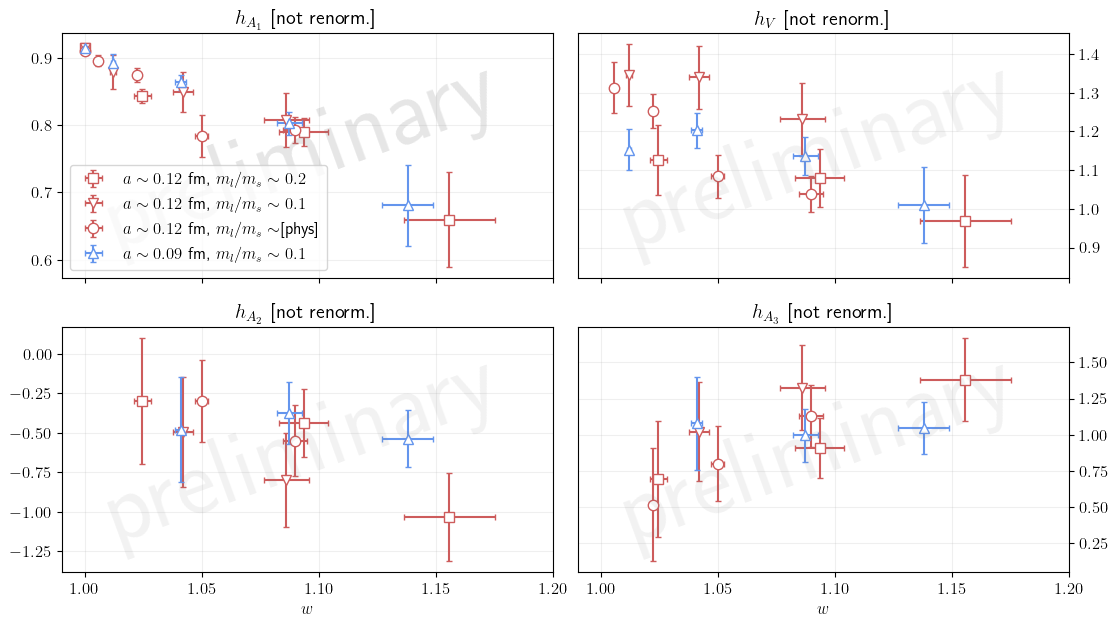

In [19]:
if MESON=='Dst':
    
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 12


    fig,ax = plt.subplots(2,2,figsize=(13,7),sharex=True)

    ah1 = ax[0,0]
    ah2 = ax[1,0]
    ah3 = ax[1,1]
    ahv = ax[0,1]


    for ens in ENSEMBLE_LIST[MESON]:
        x = ff['w'  ].loc[ens].values
        y = ff['hA1'].loc[ens].values
        ah1.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])

        x = ff['w'  ].loc[ens,mask['hA2'][ens]].values
        y = ff['hA2'].loc[ens,mask['hA2'][ens]].values
        ah2.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])

        x = ff['w'  ].loc[ens,mask['hA3'][ens]].values
        y = ff['hA3'].loc[ens,mask['hA3'][ens]].values
        ah3.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])
        
        x = ff['w'  ].loc[ens].values
        y = ff['hV'].loc[ens].values
        ahv.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])


    ax[0,1].yaxis.set_label_position("right")
    ax[0,1].yaxis.tick_right()


    ax[1,1].yaxis.set_label_position("right")
    ax[1,1].yaxis.tick_right()


    ah1.set_title(r'$h_{A_1}$ [not renorm.]')
    # ah1.set_xlabel(r'$w$')
    ah1.grid(alpha=0.2)
    ah1.set_xlim(0.99,1.2)
    ah1.set_xticks([1.,1.05,1.1,1.15,1.2])
    # ah1.legend(bbox_to_anchor=[1.3, 1.6])
    ah1.legend()

    ah1.text(0.5, 0.5, 'preliminary', transform=ah1.transAxes,
            fontsize=70, color='gray', alpha=0.1,
            ha='center', va='center', rotation=20)



    ah2.set_title(r'$h_{A_2}$ [not renorm.]')
    ah2.set_xlabel(r'$w$')
    ah2.grid(alpha=0.2)
    ah2.set_xlim(0.99,1.2)
    ah1.set_xticks([1.,1.05,1.1,1.15,1.2])

    ah3.set_title(r'$h_{A_3}$ [not renorm.]')
    ah3.set_xlabel(r'$w$')
    ah3.grid(alpha=0.2)
    ah3.set_xlim(0.99,1.2)
    ah1.set_xticks([1.,1.05,1.1,1.15,1.2])

    ahv.set_title(r'$h_{V}$ [not renorm.]'  )
    # ahv.set_xlabel(r'$w$')
    ahv.grid(alpha=0.2)
    ahv.set_xlim(0.99,1.2)
    ah1.set_xticks([1.,1.05,1.1,1.15,1.2])

    for ax in [ah1,ah2,ah3,ahv]:
        ax.text(0.5, 0.5, 'preliminary', transform=ax.transAxes,
            fontsize=70, color='gray', alpha=0.1,
            ha='center', va='center', rotation=20)



    plt.subplots_adjust(wspace=0.05, hspace=0.2)

    plt.savefig(
        f'/Users/pietro/code/latex/Lattice2024/beamer-presentation-template/PLOTS/form_factors_Dst.pdf',
        transparent=True    
    )


# Plot $D$

In [29]:
from plot_kwargs import kwargs

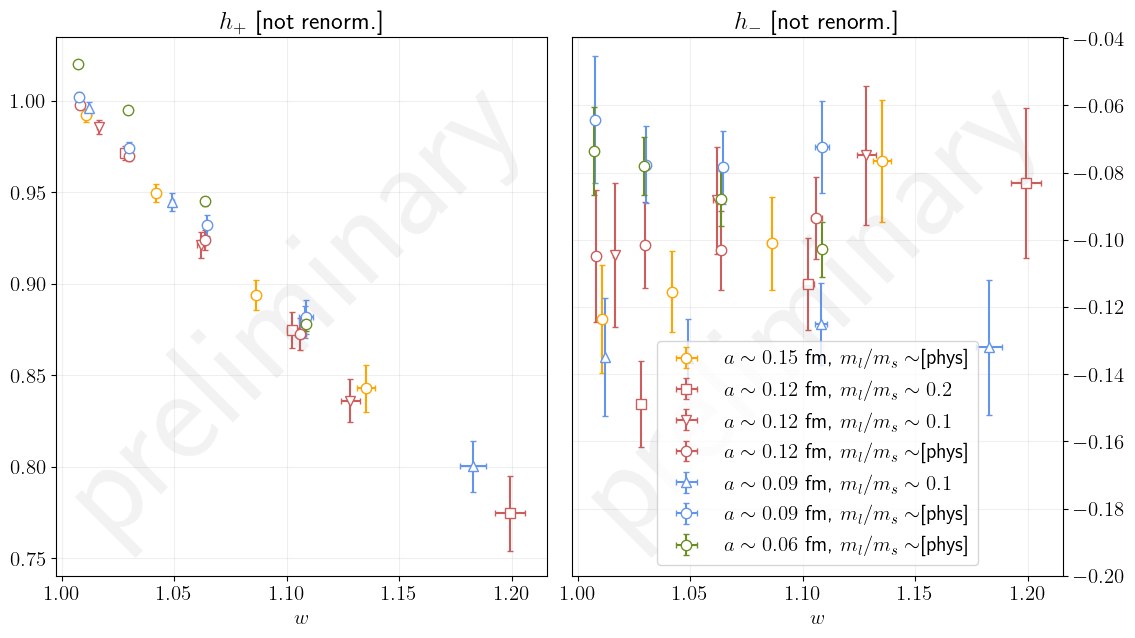

In [31]:
if MESON=='D':
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 15

    fig,ax = plt.subplots(1,2,figsize=(13,7),sharex=True)

    ap = ax[0]
    am = ax[1]


    for ens in ENSEMBLE_LIST[MESON]:
        x = ff['w' ].loc[ens].values
        y = ff['h+'].loc[ens].values
        ap.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])

        x = ff['w' ].loc[ens].values
        y = ff['h-'].loc[ens].values
        am.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])


    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()


    ap.set_title(r'$h_{+}$ [not renorm.]')
    ap.grid(alpha=0.2)
    ap.set_xlabel(r'$w$')
    # ap.legend(loc='upper right')


    am.set_title(r'$h_{-}$ [not renorm.]')
    am.grid(alpha=0.2)
    am.legend(loc='lower center')
    am.set_ylim(ymin=-0.2)
    am.set_xlabel(r'$w$')

    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    plt.subplots_adjust(wspace=0.05)

    am.text(0.5, 0.5, 'preliminary', transform=am.transAxes,
            fontsize=100, color='gray', alpha=0.1,
            ha='center', va='center', rotation=45)

    ap.text(0.5, 0.5, 'preliminary', transform=ap.transAxes,
            fontsize=100, color='gray', alpha=0.1,
            ha='center', va='center', rotation=45)


    plt.savefig(
        f'/Users/pietro/code/latex/Lattice2024/beamer-presentation-template/PLOTS/form_factors_D.pdf',
        transparent=True    
    )